# docs

- pytorch example: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
    
- pytorch colab: https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/a60617788061539b5449701ae76aee56/seq2seq_translation_tutorial.ipynb

- ntu colab: https://colab.research.google.com/drive/11iwJbQv9iScRo6kGP7YfyHaaorlHhzMT

# import

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import os

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import datasets, transforms

import time
import math

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
device

# utils

In [2]:
class Utils:
    def __init__(self):
        pass

    def asMinutes(self, s):
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)


    def timeSince(self, since, percent):
        now = time.time()
        s = now - since
        es = s / (percent)
        rs = es - s
        return '%s (- %s)' % (self.asMinutes(s), self.asMinutes(rs))
    
    def showPlot(self, points):
        plt.figure()
        fig, ax = plt.subplots()
        # this locator puts ticks at regular intervals
        loc = ticker.MultipleLocator(base=0.2)
        ax.yaxis.set_major_locator(loc)
        plt.plot(points)
        
    def showAttention(self, input_sentence, output_words, attentions):
        # Set up figure with colorbar
        fig = plt.figure(figsize=(50, 10))
        ax = fig.add_subplot(111)
        cax = ax.matshow(attentions.numpy(), cmap='bone')
        fig.colorbar(cax)

        # Set up axes
        ax.set_xticklabels([''] + input_sentence.split(' ') +
                           ['<EOS>'], rotation=90)
        ax.set_yticklabels([''] + output_words)

        # Show label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        plt.show()

    def evaluateAndShowAttention(self, myDataset, encoder, decoder, input_senText, option):
        output_words, attentions = testProcess.evaluate(myDataset, encoder, decoder, input_senText)
        output_senText = ' '.join(output_words)
        print('input =', input_senText)
        print('output =', output_senText)
        self.showAttention(input_senText, output_words, attentions)

In [ ]:
utils = Utils()

# option

In [3]:
class Option:
    def __init__(self, 
                 dropout_p=0.1, 
                 max_length=50, 
                 hidden_size=256, 
                 teacher_forcing_ratio=0.5, 
                 n_iters=10000, 
                 print_every=1000, 
                 plot_every=100, 
                 learning_rate=0.01):
        
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.hidden_size = hidden_size
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.n_iters = n_iters
        self.print_every = print_every
        self.plot_every = plot_every
        self.learning_rate = learning_rate


In [ ]:
option = Option()

# data

## todo

- 生成跟範例一樣的data

    - 用範例的方法生成dict

    - 用dataset / dataloader

In [ ]:
邏輯用簡單，一個function做一件事(命名的那件事)

## preprocess

### MyPreData

- 增加batch_size: 使用dataloader，做padding，讓長度變一樣
- 假如要加padding: 
    - gru不改，padding在句子前面
    - 改gru，可能要用雙向的 

In [4]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.setup_dict()
        
    def setup_dict(self):
        wordIndex_list = [["<SOS>", 0], ["<EOS>", 1]]
        self.word2count = {}
        self.word2index = {wordIndex[0]:wordIndex[1] for wordIndex in wordIndex_list}
        self.index2word = {wordIndex[1]:wordIndex[0] for wordIndex in wordIndex_list}
        self.n_words = len(wordIndex_list)

    def addsenText(self, senText):
        for word in senText.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            index = self.n_words
            self.word2index[word] = index
            self.index2word[index] = word
            self.word2count[word] = 1
            self.n_words += 1
        else:
            self.word2count[word] += 1

class MyPreData:
    def __init__(self):
        self.data_dir = '/media/disk3/feynman52/NTU-ML2020/hw8-Seq2seq/datasets/cmn-eng/'
    
    def read_txt(self, filename='training.txt'):
        path = os.path.join(self.data_dir, filename)
        with open(path) as f:
            content = f.readlines()
        return content
    
    def get_senText_list_pair(self, txt):
        lang1_senText_list = []
        lang2_senText_list = []
        for senText_pair in txt:
            lang1_senText, lang2_senText = senText_pair.split(' \t')
            lang1_senText = self.process_lang1_senText(lang1_senText)
            lang2_senText = self.process_lang2_senText(lang2_senText)
            lang1_senText_list.append(lang1_senText)
            lang2_senText_list.append(lang2_senText)
        senText_list_pair = lang1_senText_list, lang2_senText_list
        return senText_list_pair
    
    def process_lang1_senText(self, lang1_senText):
        lang1_senText = lang1_senText.replace('@@ ', '')
        return lang1_senText
    
    def process_lang2_senText(self, lang2_senText):
        lang2_senText = lang2_senText.strip()
        return lang2_senText
    
    def get_lang(self, name='en', senText_list=[]):
        lang = Lang(name)
        for senText in senText_list:
            lang.addsenText(senText)
        return lang
    
    def senText_to_senWord(self, senText):
        senWord = senText.split(' ')
        return senWord
    
    def senWord_to_senIndex(self, senWord, lang):
        senIndex = [lang.word2index[word] for word in senWord]
        eos_token = lang.word2index['<EOS>']
        senIndex.append(eos_token)
        return senIndex
    
    def senIndex_to_senTensor(self, senIndex):
        senTensor = torch.LongTensor(senIndex) 
        return senTensor
    
    def senText_to_senTensor(self, senText, lang):
        senWord = self.senText_to_senWord(senText)
        senIndex = self.senWord_to_senIndex(senWord, lang)
        senTensor = self.senIndex_to_senTensor(senIndex)
        return senTensor
    
    def setup_preData(self, filename='training.txt'):
        self.txt = self.read_txt(filename)

        self.lang1_senText_list, self.lang2_senText_list = self.get_senText_list_pair(self.txt)
        
        self.lang1 = self.get_lang(name='en', senText_list=self.lang1_senText_list)
        self.lang2 = self.get_lang(name='cn', senText_list=self.lang2_senText_list)

        self.lang1_senTensor_list = [self.senText_to_senTensor(senText, self.lang1) for senText in self.lang1_senText_list]
        self.lang2_senTensor_list = [self.senText_to_senTensor(senText, self.lang2) for senText in self.lang2_senText_list]
        
        


In [ ]:
# lang = Lang('cn')
# lang.word2index, lang.index2word

### steps

In [ ]:
myPreData = MyPreData()

In [ ]:
txt = myPreData.read_txt(filename='training.txt')
len(txt)
txt[0]

In [ ]:
lang1_senText_list, lang2_senText_list = myPreData.get_senText_list_pair(txt)


In [ ]:
# lang1_senText_list
# lang2_senText_list

In [ ]:
lang1 = myPreData.get_lang(name='en', senText_list=lang1_senText_list)
lang2 = myPreData.get_lang(name='cn', senText_list=lang2_senText_list)

In [ ]:
lang1.n_words, lang2.n_words
# lang1.index2word 
# lang2.index2word

In [ ]:
myPreData.setup_preData(filename='training.txt')

In [ ]:
senText = myPreData.lang1_senText_list[100]
senWord = myPreData.senText_to_senWord(senText)
senIndex = myPreData.senWord_to_senIndex(senWord, lang1)
senTensor = myPreData.senIndex_to_senTensor(senIndex)
senTensor_ = myPreData.senText_to_senTensor(senText, lang1)
senWord_ = [lang1.index2word[index] for index in senIndex]

senText, senWord, senIndex, senTensor, senTensor_, senWord_

In [ ]:
max([len(x) for x in myPreData.lang1_senTensor_list])

In [ ]:
max([len(x) for x in myPreData.lang2_senTensor_list])

## dataset

In [5]:
class MyDataset(data.Dataset):
    def __init__(self, filename='training.txt'):
        self.setup_myPreData(filename)
        
    def __len__(self):
        return len(self.myPreData.txt)
        
    def __getitem__(self, index):
        lang1_senTensor = self.myPreData.lang1_senTensor_list[index]
        lang2_senTensor = self.myPreData.lang2_senTensor_list[index]
        x = lang1_senTensor.view(-1, 1)
        y = lang2_senTensor.view(-1, 1)
        return x, y
    
    def setup_myPreData(self, filename='training.txt'):
        self.myPreData = MyPreData()
        self.myPreData.setup_preData(filename)
        
        
        

In [ ]:
myDataset = MyDataset(filename='training.txt')

In [ ]:
len(myDataset)

In [ ]:
x, y = myDataset[3]
x.shape, y.shape

## dataloader

- 長度不一樣不能用dataloader

In [ ]:
# batch_size = 1000
# myLoader = data.DataLoader(myDataset, batch_size=batch_size, shuffle=True)

In [ ]:
# batch_number = len(myLoader)
# batch_number

In [ ]:
# x, y = next(iter(myLoader))
# print(x.shape, y.shape)



# model

## encoder

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size=10, hidden_size=10):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        #print('input.shape', input.shape)
        
        x = self.embedding(input) # (1, hidden_size)
        #print('self.embedding(input)' ,x.shape)
        
        x = x.view(1, 1, -1) # (1, 1, hidden_size)
        #print('x.view(1, 1, -1)', x.shape)
        
        output, hidden = self.gru(x, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## decoder

In [7]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size=10, output_size=10, dropout_p=0.1, max_length=10):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# process

## train

In [8]:
class TrainProcess:
    def __init__(self, device, option):
        self.device = device
        self.option = option
    
    def train(self, input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
        
        encoder_hidden = encoder.initHidden()

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)

        encoder_outputs = torch.zeros(self.option.max_length, encoder.hidden_size, device=self.device)

        loss = 0

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output[0, 0]

        SOS_token = 0
        decoder_input = torch.tensor([[SOS_token]], device=self.device)

        decoder_hidden = encoder_hidden

        use_teacher_forcing = True if random.random() < self.option.teacher_forcing_ratio else False

        if use_teacher_forcing:
            # Teacher forcing: Feed the target as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                loss += criterion(decoder_output, target_tensor[di])
                decoder_input = target_tensor[di]  # Teacher forcing

        else:
            # Without teacher forcing: use its own predictions as the next input
            EOS_token = 1 #!
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input

                loss += criterion(decoder_output, target_tensor[di])
                
                if decoder_input.item() == EOS_token:
                    break

        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        return loss.item() / target_length 
    
    def trainIters(self, myDataset, encoder, decoder, utils, option):
        start = time.time()
        plot_losses = []
        print_loss_total = 0  # Reset every print_every
        plot_loss_total = 0  # Reset every plot_every

        encoder_optimizer = optim.SGD(encoder.parameters(), lr=self.option.learning_rate)
        decoder_optimizer = optim.SGD(decoder.parameters(), lr=self.option.learning_rate)
        criterion = nn.NLLLoss()
        
        for iter in range(1, self.option.n_iters + 1):
            i = random.randint(0, len(myDataset)-1)
            training_pair = myDataset[i]
            input_tensor = training_pair[0]
            target_tensor = training_pair[1]
            
            input_tensor = input_tensor.to(device) #!
            target_tensor = target_tensor.to(device)

            loss = self.train(
                input_tensor, 
                target_tensor, 
                encoder, 
                decoder, 
                encoder_optimizer, 
                decoder_optimizer, 
                criterion
            )
                        
            print_loss_total += loss
            plot_loss_total += loss

            if iter % self.option.print_every == 0:
                print_loss_avg = print_loss_total / self.option.print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (utils.timeSince(start, iter / self.option.n_iters),
                                             iter, iter / self.option.n_iters * 100, print_loss_avg))

            if iter % self.option.plot_every == 0:
                plot_loss_avg = plot_loss_total / self.option.plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

        utils.showPlot(plot_losses)

## test

In [9]:
class TestProcess:
    def __init__(self, device, option):
        self.device = device
        self.option = option
        
    def evaluate(self, myDataset, encoder, decoder, senText):
        with torch.no_grad():
            input_lang = myDataset.myPreData.lang1
            output_lang = myDataset.myPreData.lang2
            
            senTensor = myDataset.myPreData.senText_to_senTensor(senText, input_lang)
            input_tensor = senTensor.to(device) #!
            input_length = input_tensor.size()[0]
            encoder_hidden = encoder.initHidden()

            encoder_outputs = torch.zeros(self.option.max_length, encoder.hidden_size, device=self.device)

            for ei in range(input_length):
                encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
                encoder_outputs[ei] += encoder_output[0, 0]

            SOS_token = 0
            decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

            decoder_hidden = encoder_hidden

            decoded_words = []
            decoder_attentions = torch.zeros(self.option.max_length, self.option.max_length)

            EOS_token = 1
            for di in range(self.option.max_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                decoder_attentions[di] = decoder_attention.data
                topv, topi = decoder_output.data.topk(1)
                if topi.item() == EOS_token:
                    decoded_words.append('<EOS>')
                    break
                else:
                    decoded_words.append(output_lang.index2word[topi.item()])

                decoder_input = topi.squeeze().detach()

            return decoded_words, decoder_attentions[:di + 1]
        
    def evaluateRandomly(self, myDataset, encoder, decoder, n=10):
        for i in range(n):
            i_random = random.randint(0, len(myDataset)-1)
            input_senText = myDataset.myPreData.lang1_senText_list[i_random]
            target_senText = myDataset.myPreData.lang2_senText_list[i_random]
            output_words, attentions = self.evaluate(myDataset, encoder, decoder, input_senText)
            output_senText = ' '.join(output_words)
            
            print('>', input_senText)
            print('=', target_senText)
            print('<', output_senText)
            print('')

In [11]:
# myDataset.myPreData.lang2_senText_list[3]

## run

In [12]:
utils = Utils()
myDataset = MyDataset(filename='training.txt')
option = Option(n_iters=200000, max_length=40) # 3min / 10000

In [ ]:
# x, y = myDataset[0]
# x.shape, y.shape

In [13]:
encoder1 = EncoderRNN(
    input_size=myDataset.myPreData.lang1.n_words, 
    hidden_size=option.hidden_size
)
attn_decoder1 = AttnDecoderRNN(
    hidden_size=option.hidden_size, 
    output_size=myDataset.myPreData.lang2.n_words, 
    dropout_p=option.dropout_p, 
    max_length=option.max_length
)

encoder1 = encoder1.to(device)
attn_decoder1 = attn_decoder1.to(device)


In [14]:
trainProcess = TrainProcess(device, option)

In [ ]:
# trainProcess.trainIters(myDataset, encoder1, attn_decoder1, utils, option)


In [15]:
encoder1_path = './weights/encoder1-100000.pth'
attn_decoder1_path = './weights/attn_decoder1-100000.pth'


In [ ]:

# torch.save(encoder1.state_dict(), encoder1_path)
# torch.save(attn_decoder1.state_dict(), attn_decoder1_path)


In [16]:

encoder1.load_state_dict(torch.load(encoder1_path))
attn_decoder1.load_state_dict(torch.load(attn_decoder1_path))

In [17]:
testProcess = TestProcess(device, option)

In [39]:
testProcess.evaluateRandomly(myDataset, encoder1, attn_decoder1, n=10)


> she always smiles at me .
= 她 總 是 對 我 微笑 。
< 她 與 我 我 。 <EOS>

> you should come home before six .
= 你 應該 六點 前 回家 。
< 你 應該 六點 在 回家 前 回家 。 <EOS>

> i asked him to mend my shoes .
= 我 請 他 修理 我 的 鞋子 。
< 我 請 修理 我 的 鞋子 的 。 <EOS>

> she asked him to open the window .
= 她 要求 他 打開 窗戶 。
< 她 要求 他 打開 窗戶 。 <EOS>

> tom has forgotten how to do that .
= 湯姆 忘 了 怎麼 做 。
< 湯姆 有 有 有 。 <EOS>

> i spoke with him about the matter .
= 我 跟 他 談過 這個 問題 。
< 我 對 他 的 問題 很 問題 。 <EOS>

> i like you .
= 我 喜歡 你 。
< 我 喜歡 你 。 <EOS>

> i no longer love tom .
= 我 不再 愛湯姆 了 。
< 我 不再 愛湯姆 湯姆 。 <EOS>

> she has traveled all over the globe .
= 她 周遊 世界各地 。
< 她 周遊 了 所有 所有 的 。 <EOS>

> no way !
= 不 可能 ！
< 沒有 ！ <EOS>



input = she asked him to open the window .
output = 她 要求 他 打開 窗戶 <EOS>


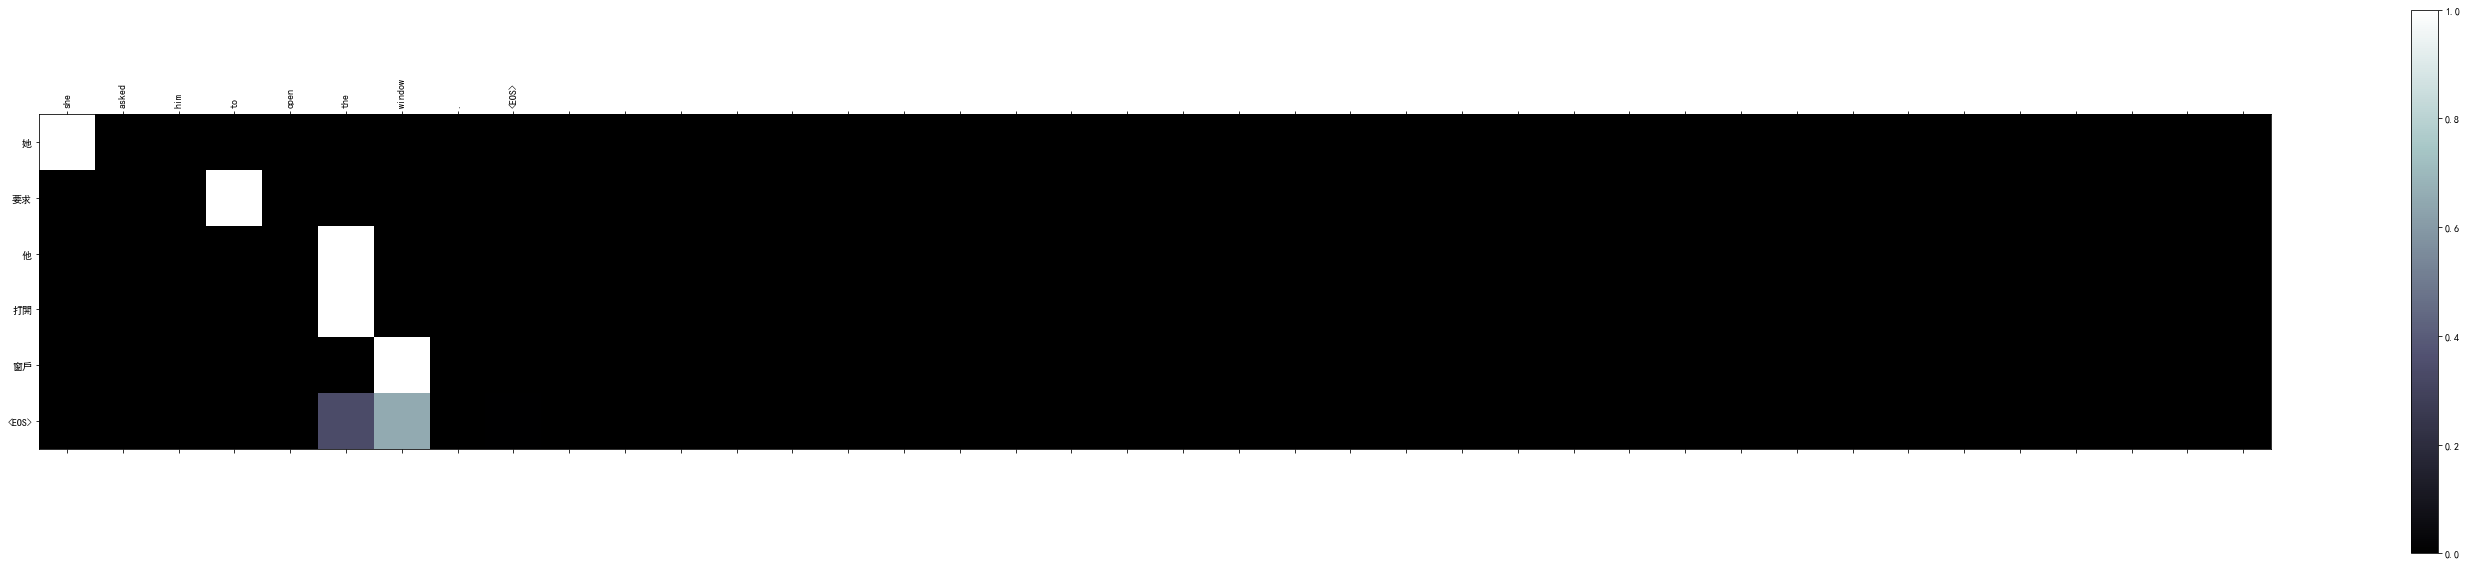

In [40]:
senText_list = [
    'thanks for your quick answer .', 
    'you are very early this morning .',
    'she gave me a smile of recognition .',
    'he plays tennis very well .',
    'my hometown is very pretty .',
    'he grew up in germany .',
    "i could n't agree with his opinion .",
    "i 'd like to pay in cash .",
    'children like chocolate .',
    "i ca n't ask tom right now .",
    "i 'm the tallest in our class .",
    "she asked him to open the window ."
]

senText = senText_list[-1]
senText

# output_words, attentions = testProcess.evaluate(myDataset, encoder1, attn_decoder1, senText)
# plt.matshow(attentions.numpy())

utils.evaluateAndShowAttention(myDataset, encoder1, attn_decoder1, senText, option)

#? output 每次不太一樣

In [ ]:
book bo"@@ "ok